In [1]:
using Plots
using Statistics
using StatsBase 
using Distributions
using LinearAlgebra
using IntervalSets
using Random 
using ArraysOfArrays
using ValueShapes
using Measurements
import BAT 
using MultivariateStats
using Clustering
using Measurements
using BenchmarkTools
using Parameters

pyplot()

# using PyPlot

Plots.PyPlotBackend()

# 1. Densities

Activate the desired distribution:  

## 1.1 Multivariate Normal Distribution:

In [2]:
# no correltions: 

n_dims = 10
σ = 1
distribution = BAT.MvNormal(n_dims,σ)

prior = BAT.NamedTupleDist(
    x = repeat([-5.0 .. 5.0], n_dims),
);

truth_int = 1/10^n_dims

1.0e-10

In [ ]:
# Σ = [3.426818298733095 12.378238116671048 -9.632531611142456; 
#     12.378238116671048 69.83909693165143 -43.478993858310886; 
#     -9.632531611142456 -43.478993858310886 60.0626256206892]

# μ = [8.959570984309234, -9.021529871694005, -5.007789383392622]

# n_dims = 3 

# distribution = MvNormal(μ, Σ)

# prior = NamedTupleDist(
#     x = repeat([-50.0 .. 50.0], n_dims),
# );

## 1.2 Gaussian Mixture Model (3D): 

In [16]:
# n_dims = 3 

# σ_1 = [3.426818298733095 12.378238116671048 -9.632531611142454; 3.426818298733095 4.916266580684483 -5.029942800849483; 3.426818298733095 -6.737309268887753 5.4343957706004415; 3.426818298733095 -3.9729587574454333 3.379361860370276]
# σ_2 = [12.378238116671048 69.83909693165143 -43.478993858310886; 4.916266580684482 69.83909693165143 -64.18784570966332; -6.737309268887753 69.83909693165143 32.734776615550174; -3.972958757445433 69.83909693165143 53.74871853095418]
# σ_3 = [-9.632531611142456 -43.478993858310886 60.0626256206892; -5.029942800849484 -64.18784570966332 60.0626256206892; 5.4343957706004415 32.734776615550174 60.0626256206892; 3.3793618603702757 53.74871853095418 60.0626256206892]
# σ = cat(σ_1,σ_2,σ_3, dims=3)

# μ = [8.959570984309234 -9.021529871694005 -5.007789383392622; -1.446445514344754 -7.8327010768703875 -3.2653263028963986; -6.40954093270941 0.25815094665222027 5.830143596540282; 5.076504517881521 -0.8952973253675331 9.16356325348496]

# distribution = MixtureModel(MvNormal[MvNormal(μ[i,:], Matrix(Hermitian(σ[i,:,:])) ) for i in 1:4]);

# prior = NamedTupleDist(
#     x = repeat([-50.0 .. 50.0], n_dims),
# );

## 1.3 Funnel Distribution: 

In [58]:
n_dims = 4

distribution = BAT.FunnelDistribution(n=n_dims)

prior = NamedTupleDist(
    x = repeat([-50.0 .. 50.0], n_dims),
);

truth_int = 1/100^n_dims

1.0e-8

## 1.4 Caushy Distribution: 

In [56]:
n_dims = 2

distribution = BAT.MultimodalCauchy(n=n_dims);

prior = NamedTupleDist(
    x = repeat([-10.0 .. 10.0], n_dims),
);

## 1.5 Gaussian Shell: 

In [57]:
n_dims = 2

distribution = BAT.GaussianShell(n=n_dims, r=10);

prior = NamedTupleDist(
    x = repeat([-50.0 .. 50.0], n_dims),
);

# 2. Sampling

In [59]:
log_likelihood = let dist = distribution
    params -> begin
        BAT.LogDVal(logpdf(dist, params.x))
    end
end

posterior = BAT.PosteriorDensity(log_likelihood, prior);

In [60]:
nsamples = 10^5

100000

In [61]:
samples = BAT.bat_sample(
    posterior, 
    nsamples, BAT.MCMCSampling(sampler = BAT.MetropolisHastings(), nchains = 4)
).result; 

┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64,10}
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Trying to generate 4 viable MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/chain_pool_init.jl:63
┌ Info: Selected 4 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/chain_pool_init.jl:185
┌ Info: Begin tuning of 4 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/multi_cycle_burnin.jl:38
┌ Info: MCMC Tuning cycle 1 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/multi_cycle_burnin.jl:70
┌ Info: MCMC Tuning cycle 2 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/multi_cycle_burnin.jl:70
┌ Info: MCMC Tuning cycle 3 finished, 4 chains, 0 tuned, 4 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/s

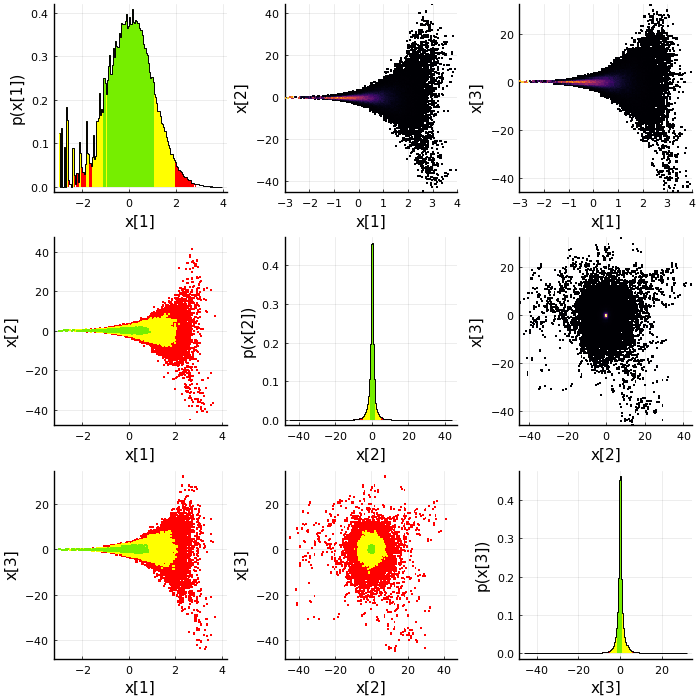

In [62]:
plot(samples, vsel=1:3, size=(700, 700))

# 3. Integration

In [50]:
include("../src/whitening.jl")
include("../src/clustering.jl")
include("../src/volumes.jl")
include("../src/integration.jl")

compute_hm (generic function with 1 method)

In [63]:
# whitening = Standardizing()
whitening = EigenDecompos()
# whitening = PartialEigenDecompos(steep_edges_ind = [])

clustering = KMeans(
    nclusters = [1, 2, 4, 8, 16, ] #32,]
)

volumes = HyperRectangle()

int_alg = AHMIntegration(whitening=whitening, clustering=clustering, volumes=volumes)

AHMIntegration{EigenDecompos,KMeans,HyperRectangle}
  whitening: EigenDecompos EigenDecompos()
  clustering: KMeans
  volumes: HyperRectangle HyperRectangle()


In [64]:
@time output = bat_integrate(samples, int_alg);

┌ Info: Iteration 1/5
└ @ Main /Users/vhafych/MPP-Server/gitrepos/AHMI-Volumes/src/integration.jl:38
┌ Info: Iteration 2/5
└ @ Main /Users/vhafych/MPP-Server/gitrepos/AHMI-Volumes/src/integration.jl:38
┌ Info: Iteration 3/5
└ @ Main /Users/vhafych/MPP-Server/gitrepos/AHMI-Volumes/src/integration.jl:38
┌ Info: Iteration 4/5
└ @ Main /Users/vhafych/MPP-Server/gitrepos/AHMI-Volumes/src/integration.jl:38
┌ Info: Iteration 5/5
└ @ Main /Users/vhafych/MPP-Server/gitrepos/AHMI-Volumes/src/integration.jl:38


  3.024392 seconds (9.77 k allocations: 582.863 MiB, 18.92% gc time)


In [65]:
run_result = output.result

9.77e-9 ± 4.2e-10

In [66]:
run_int_estimates = output.int_estimates
run_log_vol = output.log_vol
deb = output.debug;

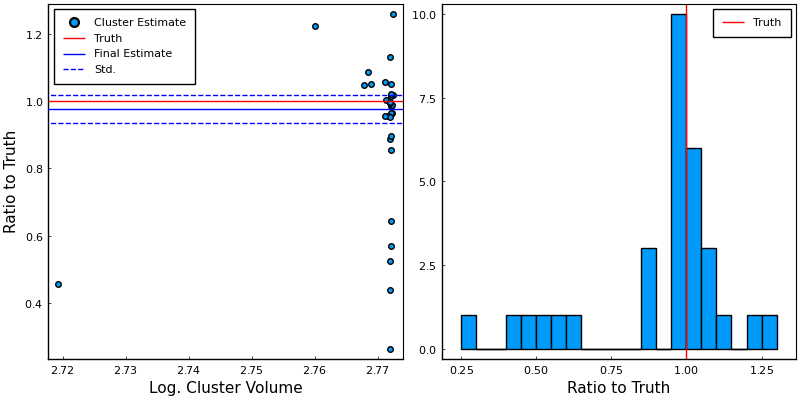

In [67]:
p1 = scatter(
    run_log_vol, 
    run_int_estimates./truth_int, 
    label="Cluster Estimate",
    xlabel = "Log. Cluster Volume",
    ylabel = "Ratio to Truth", frame=true)

p1 = hline!([1], label="Truth", color="red")

p1 = hline!([run_result.val]./truth_int, 
    label="Final Estimate", 
    color="blue")

p1 = hline!([run_result.val - run_result.err, run_result.val + run_result.err]./truth_int, 
    label="Std.", 
    color="blue", linestyle=:dash, grid=false)

p2 = histogram(run_int_estimates./truth_int, nbins=30, 
    frame=true, 
    label="", 
    xlabel = "Ratio to Truth", )

p2 = vline!([1.0], label="Truth", color="red", grid=false)

plot(p1, p2, size=(800, 400))

In [68]:
function make_debug_plot(data, ind; x=1, y=2)
    
    nt_data = data[ind].smpls
    clst_mask = data[ind].cl_mask
    clst_cent = data[ind].cl_center
    vol_mask = data[ind].volume
    
    p1 = scatter(nt_data[x, :], nt_data[y, :], color=palette(:Paired_3)[1], markersize=2, markerstrokewidth=0.0, label="Samples", frame=true, size=(500, 500))
    p1 = scatter!(nt_data[x, clst_mask], nt_data[y, clst_mask], color=palette(:OrRd_3)[2], markersize=2, markerstrokewidth=0.0, label="Cluster")
    p1 = scatter!(nt_data[x, vol_mask], nt_data[y, vol_mask], color=palette(:OrRd_3)[3], markersize=2, markerstrokewidth=0.0, label="Samples", frame=true)
    p1 = scatter!([clst_cent[x]],[clst_cent[y]], color="black", markersize=10, markerstrokewidth=0.0, label="Cluster Center")
    p1 = plot!(xlabel=x, ylabel=y, grid=false)
    return p1
end

make_debug_plot (generic function with 1 method)

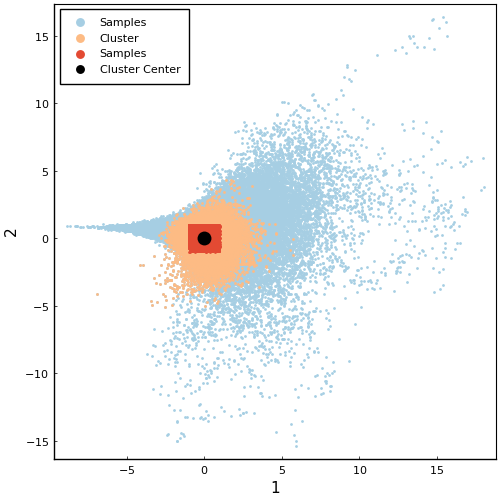

In [69]:
make_debug_plot(deb, 15)

In [71]:
# length(deb)

31

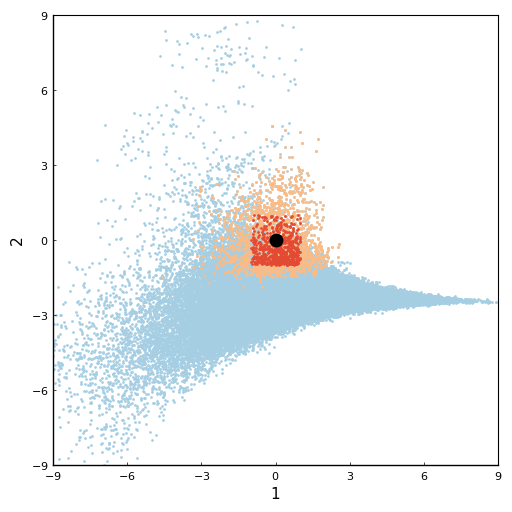

┌ Info: Saved animation to 
│   fn = /Users/vhafych/MPP-Server/gitrepos/AHMI-Volumes/notebooks/anim_fps15.gif
└ @ Plots /Users/vhafych/.julia/packages/Plots/vsE7b/src/animation.jl:104


Plots.AnimatedGif("/Users/vhafych/MPP-Server/gitrepos/AHMI-Volumes/notebooks/anim_fps15.gif")
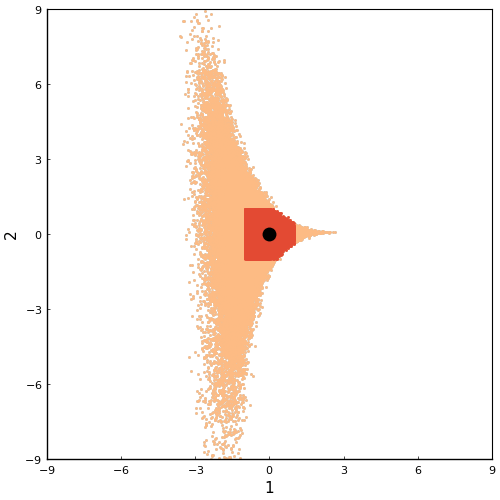

In [72]:
function make_animation(data, ind; x=1, y=2, xrange=(-9, 9), yrange=(-9, 9))
    
    nt_data = data[ind].smpls
    clst_mask = data[ind].cl_mask
    clst_cent = data[ind].cl_center
    vol_mask = data[ind].volume
    
    p1 = scatter(nt_data[x, :], nt_data[y, :], color=palette(:Paired_3)[1], markersize=2, markerstrokewidth=0.0, label="Samples", frame=true, size=(500, 500))
    p1 = scatter!(nt_data[x, clst_mask], nt_data[y, clst_mask], color=palette(:OrRd_3)[2], markersize=2, markerstrokewidth=0.0, label="Cluster")
    p1 = scatter!(nt_data[x, vol_mask], nt_data[y, vol_mask], color=palette(:OrRd_3)[3], markersize=2, markerstrokewidth=0.0, label="Samples", frame=true)
    p1 = scatter!([clst_cent[x]],[clst_cent[y]], color="black", markersize=10, markerstrokewidth=0.0, label="Cluster Center")
    p1 = plot!(xlabel=x, ylabel=y, grid=false, xlim=xrange, ylim=yrange, legend=false)
    return p1
end

anim = @animate for i in 1:30
    make_animation(deb, i)
end;

gif(anim, "anim_fps15.gif", fps = 2)

    To do: 
    
    1) Use Log scale for integral estimates
    2) Use threads/workers parallelization 
    3) Think whether dataset splitting is needed 
    4) Try different volumes